In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [2]:
#model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='swish', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='elu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='swish'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='elu'))
model.add(layers.Dense(10))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_split = 0.15, verbose = 2)

Epoch 1/10
1329/1329 - 58s - loss: 1.4541 - accuracy: 0.4791 - val_loss: 1.2804 - val_accuracy: 0.5520
Epoch 2/10
1329/1329 - 56s - loss: 1.1217 - accuracy: 0.6041 - val_loss: 1.0529 - val_accuracy: 0.6349
Epoch 3/10
1329/1329 - 56s - loss: 0.9561 - accuracy: 0.6638 - val_loss: 1.0085 - val_accuracy: 0.6492
Epoch 4/10
1329/1329 - 52s - loss: 0.8430 - accuracy: 0.7022 - val_loss: 0.9054 - val_accuracy: 0.6845
Epoch 5/10
1329/1329 - 51s - loss: 0.7524 - accuracy: 0.7364 - val_loss: 0.9272 - val_accuracy: 0.6824
Epoch 6/10
1329/1329 - 51s - loss: 0.6667 - accuracy: 0.7657 - val_loss: 0.9074 - val_accuracy: 0.6949
Epoch 7/10
1329/1329 - 49s - loss: 0.5942 - accuracy: 0.7896 - val_loss: 0.9389 - val_accuracy: 0.6916
Epoch 8/10
1329/1329 - 53s - loss: 0.5211 - accuracy: 0.8139 - val_loss: 0.9189 - val_accuracy: 0.7135
Epoch 9/10
1329/1329 - 52s - loss: 0.4593 - accuracy: 0.8364 - val_loss: 0.9659 - val_accuracy: 0.7035
Epoch 10/10
1329/1329 - 52s - loss: 0.4028 - accuracy: 0.8558 - val_loss:

In [3]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

313/313 - 4s - loss: 1.1086 - accuracy: 0.6916


In [4]:
print("baseline testing accuracy: %.3f" %test_acc)

import numpy as np

#model prediction probability 
model_prob = model.predict(test_images)

#use max() to get from prob -> prediction
model_predictions = []

#model_predictions
for prob in model_prob: 
    pred = tf.math.argmax(prob)
    ind = pred.numpy()
    model_predictions.append(ind)

baseline testing accuracy: 0.692


In [5]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

# compute signed gradient of the loss w.r.t to input image
def adv(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)
    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

#create adversarial image using signed gradient * epsilon
def adv_images(test_images, test_labels, epsilon):
    adv_results = []
    for im,label in zip(test_images, test_labels):
        im = tf.convert_to_tensor([im])
        label = tf.one_hot(label, 10)
        label = tf.reshape(label, (1,10))
        #get sign gradient 
        signed_grad = adv(im, label)
        #create adversary 
        adv_image = im + epsilon*signed_grad
        # normalize adversarial image to [0,1]
        adv_image = (adv_image + epsilon) / (1 + 2 * epsilon)
        # clip out floating point errors
        adv_image = tf.clip_by_value(adv_image, clip_value_min=0, clip_value_max=1)
        adv_results.append(adv_image)
    return adv_results

In [6]:
#compare results from base model with FGSM

#find highest classification probabilty from model
def prob_to_class(input_images):
    class_predictions = []
    prob = model.predict(input_images)
    for p in prob: 
        pred = tf.math.argmax(p)
        ind = pred.numpy()
        class_predictions.append(ind)
    return class_predictions
        

In [7]:
# run attack on different epsilon and show examples of successful attacks
def fgsm_attack(model_predictions, test_images, test_labels, epsilon):
    fgsm_images = adv_images(test_images, test_labels, epsilon)
    fgsm_images = tf.convert_to_tensor(fgsm_images)
    fgsm_images = tf.reshape(fgsm_images, (10000, 32, 32, 3))
    fgsm_predictions = prob_to_class(fgsm_images)

    num_success = 0
    ind = 0
    success = []
    for model_pred, fgsm_pred, true in zip(model_predictions, fgsm_predictions, test_labels):
        true = true[0]
        # successful misclassification: model initially predicted correct but now misclassifies
        if model_pred == true and model_pred != fgsm_pred:
            num_success += 1
            success_case = (ind, fgsm_pred, true)
            success.append(success_case)
        ind += 1
        
    return fgsm_images, num_success/10000, success
    

In [8]:
import random
#display findings
def display_results(test_images, test_labels, successful, fgsm_images, epsilon):
    # compare 3 random misclassified images to true labels
    plt.figure(figsize=(10,10))
    ax = []
    num_ex = 3
    ex1 = random.randint(0,len(successful))
    ex2 = int(ex1/2)+ 1
    ex3 = ex2 + 1
    ex = [ex1, ex2, ex3]
    plot_ind = 1
    for i in ex:
        ind, fgsm_pred, true = successful[i]
        plt.figure(figsize=(10,10))
        plt.subplot(3,2,plot_ind)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(fgsm_images[ind], cmap=plt.cm.binary)
        mis_title = "epsilon = {e}\tMisclassified as: {pred}".format(e = epsilon, pred = class_names[fgsm_pred])
        plt.xlabel(mis_title)
        plt.subplot(3,2,plot_ind+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(test_images[ind], cmap=plt.cm.binary)
        true_title = "epsilon = {e}\tTrue Label: {pred}".format(e = epsilon, pred = class_names[true])
        plt.xlabel(true_title)
        plot_ind += 2
    plt.show()
  


In [9]:
def fgsm_result(test_images, test_labels, model_predictions):
    epsilon = [0.01,0.05, 0.1, 0.15, 0.2]
    for e in epsilon:
        #get adversarial images
        fgsm_images, accuracy, success = fgsm_attack(model_predictions, test_images, test_labels, e)
        #display visual result:
        print("epsilon value:", e, "fgsm attack accuracy:", accuracy)
        display_results(test_images, test_labels, success, fgsm_images, e)
    
# fgsm_result(test_images, test_labels, model_predictions)
        

In [10]:
# Iterative FGSM: 

In [11]:
def ifgsm_adv(test_images, test_labels, epsilon, alpha, iteration):
    adv_results = []
    for im,label in zip(test_images, test_labels):
        original = tf.convert_to_tensor([im])
        label = tf.one_hot(label, 10)
        label = tf.reshape(label, (1,10))
        #iterative attack
        adv_image = original
        
        
        #debugging::
        print("im shape:", tf.shape(adv_image))
        print("label shape:",tf.shape(label))
        
        for i in range(iteration):
            signed_grad = adv(adv_image, label)
            adv_image = adv_image + alpha * signed_grad
            diff = adv_image - original
            diff = tf.clip_by_value(diff, clip_value_min=-epsilon, clip_value_max=epsilon)
            adv_image = original + diff
            # normalize to [0,1]
            adv_image = (adv_image + epsilon) / (1 + 2 * epsilon)
            adv_image = tf.clip_by_value(adv_image, clip_value_min=0, clip_value_max=1)
        adv_results.append(adv_image)
    return adv_results


In [12]:
def ifgsm_attack(model_predictions, test_images, test_labels, epsilon, alpha, iteration):
    ifgsm_images = ifgsm_adv(test_images, test_labels, epsilon, alpha, iteration)
    ifgsm_images = tf.convert_to_tensor(ifgsm_images)
    ifgsm_images = tf.reshape(ifgsm_images, (10000, 32, 32, 3))
    ifgsm_predictions = prob_to_class(ifgsm_images)

    num_success = 0
    ind = 0
    success = []
    for model_pred, ifgsm_pred, true in zip(model_predictions, ifgsm_predictions, test_labels):
        true = true[0]
        # successful misclassification: model initially predicted correct but now misclassifies
        if model_pred == true and model_pred != ifgsm_pred:
            num_success += 1
            success_case = (ind, ifgsm_pred, true)
            success.append(success_case)
        ind += 1
        
    return ifgsm_images, num_success/10000, success

In [13]:
def ifgsm_display_results(test_images, test_labels, successful, fgsm_images, epsilon, alpha, iteration):
    # compare 3 random misclassified images to true labels
    plt.figure(figsize=(10,10))
    ax = []
    num_ex = 3
    ex1 = random.randint(0,len(successful))
    ex2 = int(ex1/2)+ 1
    ex3 = ex2 + 1
    ex = [ex1, ex2, ex3]
    plot_ind = 1
    for i in ex:
        ind, fgsm_pred, true = successful[i]
        plt.figure(figsize=(10,10))
        plt.subplot(3,2,plot_ind)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(fgsm_images[ind], cmap=plt.cm.binary)
        mis_title = "e,a,iteration = {e},{a},{i}\tMisclassified as: {pred}".format(e = epsilon, a=alpha, i=iteration, pred = class_names[fgsm_pred])
        plt.xlabel(mis_title)
        plt.subplot(3,2,plot_ind+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(test_images[ind], cmap=plt.cm.binary)
        true_title = "e,a,iteration = {e},{a},{i}\tTrue Label: {pred}".format(e = epsilon, a=alpha, i=iteration, pred = class_names[true])
        plt.xlabel(true_title)
        plot_ind += 2
    plt.show()

In [14]:
def ifgsm_result(test_images, test_labels, model_predictions, epsilon, alpha, iteration):
    #get adversarial images
    ifgsm_images, accuracy, success = ifgsm_attack(model_predictions, test_images, test_labels, epsilon, alpha, iteration)
    #display visual result:
    print("epsilon value:", epsilon, "alpha:", alpha, "iteration:",iteration, "fgsm attack accuracy:", accuracy)
    ifgsm_display_results(test_images, test_labels, success, ifgsm_images, epsilon, alpha, iteration)

In [15]:
# alpha = 0.1, iteration = 5
# ifgsm_result(test_images, test_labels, model_predictions, 0.1, 0.1, 5)

In [16]:
# #e = 0.05, a = 0.1, iteration = 10
# ifgsm_result(test_images, test_labels, model_predictions, 0.01, 0.1, 10)

In [17]:
# ifgsm_result(test_images, test_labels, model_predictions, 0.05, 0.1, 10)

In [18]:
# ifgsm_result(test_images, test_labels, model_predictions, 0.1, 0.1, 10)

In [19]:
#ifgsm_result(test_images, test_labels, model_predictions, 0.2, 0.1, 5)

In [20]:
#ifgsm_result(test_images, test_labels, model_predictions, 0.2, 0.1, 10)

In [21]:
#ifgsm_result(test_images, test_labels, model_predictions, 0.01, 0.5, 5)

In [22]:
#ifgsm_result(test_images, test_labels, model_predictions, 0.05, 0.5, 5)

In [23]:
#ifgsm_result(test_images, test_labels, model_predictions, 0.1, 0.5, 5)

In [24]:
# Least Likely FGSM
# generate LL-FGSM images
def llfgsm_adv(test_images, model_prob, epsilon, alpha, iteration):
    adv_results = []
    least_labels = []
    
    for im,prob in zip(test_images, model_prob):
        original = tf.convert_to_tensor([im])
        #least-likely label
        label = tf.one_hot(np.argmin(prob), 10)
        label = tf.reshape(label, (1,10))
        least_labels.append(np.argmin(prob))
        adv_image = original
        
#         print("image shape:", tf.shape(adv_image))
        
        for i in range(iteration):
            signed_grad = adv(adv_image, label)
            adv_image = adv_image - alpha * signed_grad
            
            diff = adv_image - original
            diff = tf.clip_by_value(diff, clip_value_min=-epsilon, clip_value_max=epsilon)
            adv_image = original + diff
            
            # normalize to [0,1]
            adv_image = (adv_image + epsilon) / (1 + 2 * epsilon)
            adv_image = tf.clip_by_value(adv_image, clip_value_min=0, clip_value_max=1)
        adv_results.append(adv_image)

    return adv_results, least_labels


In [25]:
# perform LL-FGSM attack on test images
def llfgsm_attack(model_predictions, model_prob, test_images, test_labels, epsilon, alpha, iteration):
    #create llfgsm images and get model prediction
    llfgsm_images, least_labels = llfgsm_adv(test_images, model_prob, epsilon, alpha, iteration)
    llfgsm_images = tf.convert_to_tensor(llfgsm_images)
    llfgsm_images = tf.reshape(llfgsm_images, (10000, 32, 32, 3))
    llfgsm_predictions = prob_to_class(llfgsm_images)

    num_success = 0
    ind = 0
    success = []
    
    #record accuracy and successful attacks
    for model_pred, llfgsm_pred, true in zip(model_predictions, llfgsm_predictions, test_labels):
        true = true[0]
        # successful misclassification: model initially predicted correct but now misclassifies
        if model_pred == true and model_pred != llfgsm_pred:
            num_success += 1
            
            success_case = (ind, llfgsm_pred, true)
            success.append(success_case)
        ind += 1
        
    return llfgsm_images, num_success/10000, success, least_labels

In [31]:
# run and display LL-FGSM attack on test images 
def llfgsm_display_results(test_images, test_labels, successful, fgsm_images, least_labels, epsilon, alpha, iteration):
    # compare 3 random misclassified images to true labels
    plt.figure(figsize=(10,10))
    ax = []
    num_ex = 3
    ex1 = random.randint(0,len(successful))
    ex2 = int(ex1/2)+ 1
    ex3 = ex2 + 1
    ex = [ex1, ex2, ex3]
    plot_ind = 1
    for i in ex:
        ind, fgsm_pred, true = successful[i]
        plt.figure(figsize=(10,10))
        plt.subplot(3,2,plot_ind)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(fgsm_images[ind], cmap=plt.cm.binary)
        mis_title = "Least_Label: {label}\tMisclassified as: {pred}".format(label = class_names[least_labels[i]], pred = class_names[fgsm_pred])
        plt.xlabel(mis_title)
        plt.subplot(3,2,plot_ind+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(test_images[ind], cmap=plt.cm.binary)
        true_title = "True Label: {pred}".format(pred = class_names[true])
        plt.xlabel(true_title)
        plot_ind += 2
    plt.show()

In [32]:
def llfgsm_result(test_images, test_labels, model_predictions, epsilon, alpha, iteration):
    #get adversarial images
    llfgsm_images, accuracy, success, least = llfgsm_attack(model_predictions, model_prob, test_images, test_labels, epsilon, alpha, iteration)
    
    #display visual result
    print("epsilon value:", epsilon, "alpha:", alpha, "iteration:",iteration, "LL-FGSM attack accuracy:", accuracy)
    llfgsm_display_results(test_images, test_labels, success, llfgsm_images, least, epsilon, alpha, iteration)

epsilon value: 0.01 alpha: 0.1 iteration: 5 LL-FGSM attack accuracy: 0.0228


<Figure size 720x720 with 0 Axes>

/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


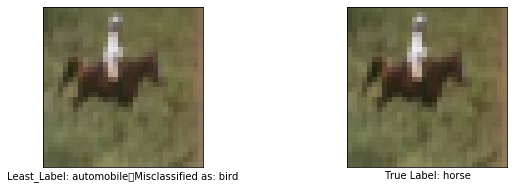

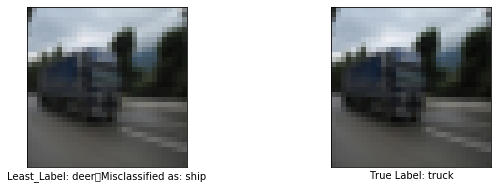

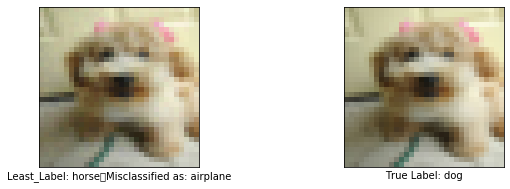

In [33]:
# e= 0.01, a = 0.1, iteration = 5
llfgsm_result(test_images, test_labels, model_predictions, 0.01, 0.1, 5)

epsilon value: 0.05 alpha: 0.1 iteration: 5 LL-FGSM attack accuracy: 0.1131


<Figure size 720x720 with 0 Axes>

/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


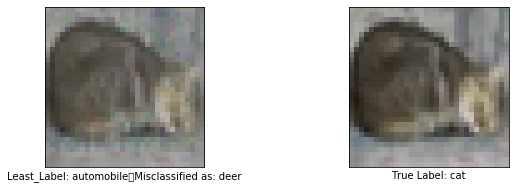

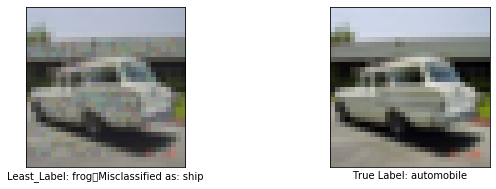

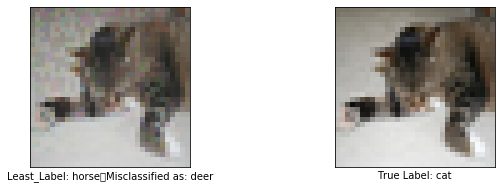

In [34]:
# e= 0.05, a=0.1, iteration = 5
llfgsm_result(test_images, test_labels, model_predictions, 0.05, 0.1, 5)